# Feature Selection or PCA?
Escolhi seguir com o feature selection, dado que a interpretabilidade é importante

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    train_test_split,
    TunedThresholdClassifierCV,
    StratifiedKFold,
)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import clone

from project_ml_course.data_process import filter_columns_by_correlation_threshold

# Load Data

In [ ]:
raw_df = pd.read_csv("../data/dados.csv", index_col="Unnamed: 0")

df = filter_columns_by_correlation_threshold(
    df=raw_df,
    ref_col="class",
    method_type="pearson",
    lower_threshold=0.001,
    higher_threshold=0.999,
)

# Separar X e y
X = df.drop(columns=["class"])
y = df["class"]

# Separar treino e teste
X_train, _, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature Selection

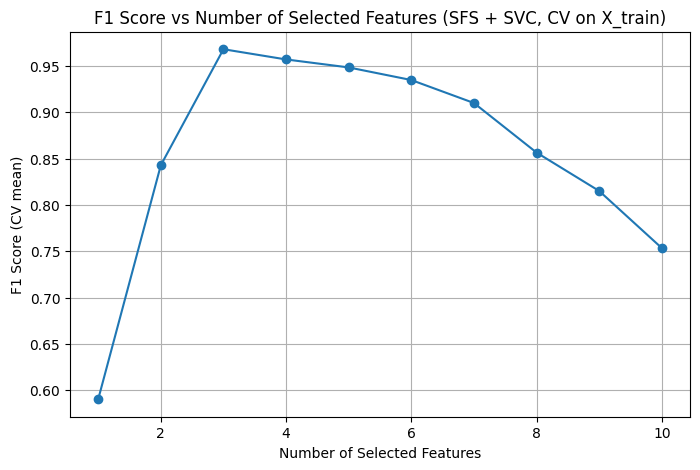

In [24]:
results = []
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for n_features in range(1, 11):
    fold_scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clf = Pipeline([("classification", SVC())])
        sfs = SequentialFeatureSelector(clf, n_features_to_select=n_features)
        sfs.fit(X_tr, y_tr)
        X_tr_selected = sfs.transform(X_tr)
        X_val_selected = sfs.transform(X_val)

        clf_selected = clone(clf)
        clf_selected.fit(X_tr_selected, y_tr)
        y_pred = clf_selected.predict(X_val_selected)
        score = f1_score(y_val, y_pred)
        fold_scores.append(score)
    avg_score = np.mean(fold_scores)
    results.append({"n_features": n_features, "f1_score": avg_score})

results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.plot(results_df["n_features"], results_df["f1_score"], marker="o")
plt.xlabel("Number of Selected Features")
plt.ylabel("F1 Score (CV mean)")
plt.title("F1 Score vs Number of Selected Features (SFS + SVC, CV on X_train)")
plt.grid(True)
plt.show()

In [25]:
clf = Pipeline([("classification", SVC())])
sfs = SequentialFeatureSelector(clf, n_features_to_select=3)
sfs.fit(X_train, y_train)

,estimator,"Pipeline(step...ion', SVC())])"
,n_features_to_select,3
,tol,None
,direction,'forward'
,scoring,None
,cv,5
,n_jobs,None
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [26]:
[X_train.columns[i] for i in range(len(X_train.columns)) if sfs.get_support()[i]]

['feat_8', 'feat_17', 'feat_50']

In [27]:
results_df

,n_features,f1_score
0,1,0.590253
1,2,0.842906
2,3,0.968127
3,4,0.957091
4,5,0.948465
5,6,0.934857
6,7,0.910030
7,8,0.856520
8,9,0.815068
9,10,0.753410


# PCA

In [10]:
raw_df = pd.read_csv("../data/dados.csv", index_col="Unnamed: 0")

df = filter_columns_by_correlation_threshold(
    df=raw_df,
    ref_col="class",
    method_type="pearson",
    lower_threshold=0.001,
    higher_threshold=0.999,
)

# Separar X e y
X = df.drop(columns=["class"])
y = df["class"]

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

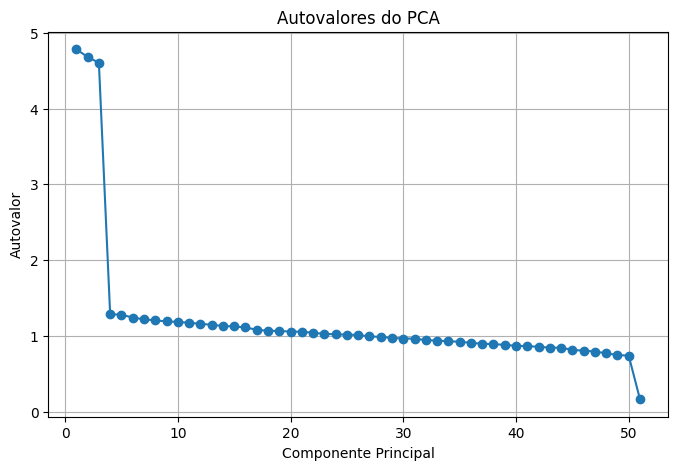

In [7]:
# Criar pipeline com StandardScaler e PCA
pipeline = Pipeline([("scaler", StandardScaler(with_std=False)), ("pca", PCA())])

# Ajustar pipeline nos dados (removendo a coluna alvo se necessário)
X = raw_df.drop(columns=["class"])
pipeline.fit(X)

# Analisar os autovalores (variância explicada)
autovalores = pipeline.named_steps["pca"].explained_variance_

# Plotar os autovalores
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(autovalores) + 1), autovalores, marker="o")
plt.title("Autovalores do PCA")
plt.xlabel("Componente Principal")
plt.ylabel("Autovalor")
plt.grid(True)
plt.show()

In [11]:
f1_scores = []
n_components_range = range(1, X.shape[1] + 1)

for n_components in n_components_range:
    base_pipeline = Pipeline(
        [
            ("scaler", StandardScaler(with_std=False)),
            ("pca", PCA(n_components=n_components)),
            ("clf", SVC()),
        ]
    )

    model = TunedThresholdClassifierCV(
        estimator=base_pipeline,
        thresholds=np.arange(0, 1.0, 0.01),
        cv=5,
        scoring="f1",
        random_state=42,
        store_cv_results=True,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

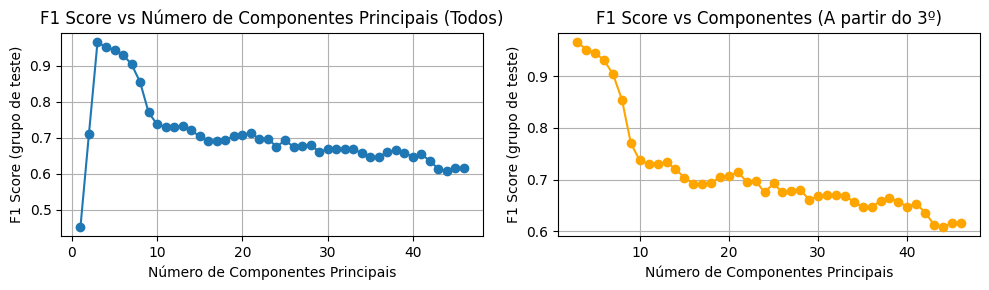

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Chart 1: All components
axes[0].plot(n_components_range, f1_scores, marker="o")
axes[0].set_title("F1 Score vs Número de Componentes Principais (Todos)")
axes[0].set_xlabel("Número de Componentes Principais")
axes[0].set_ylabel("F1 Score (grupo de teste)")
axes[0].grid(True)

# Chart 2: After 3 components
axes[1].plot(n_components_range[2:], f1_scores[2:], marker="o", color="orange")
axes[1].set_title("F1 Score vs Componentes (A partir do 3º)")
axes[1].set_xlabel("Número de Componentes Principais")
axes[1].set_ylabel("F1 Score (grupo de teste)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [22]:
list(zip(n_components_range, f1_scores))[2]

(3, 0.9657320872274143)

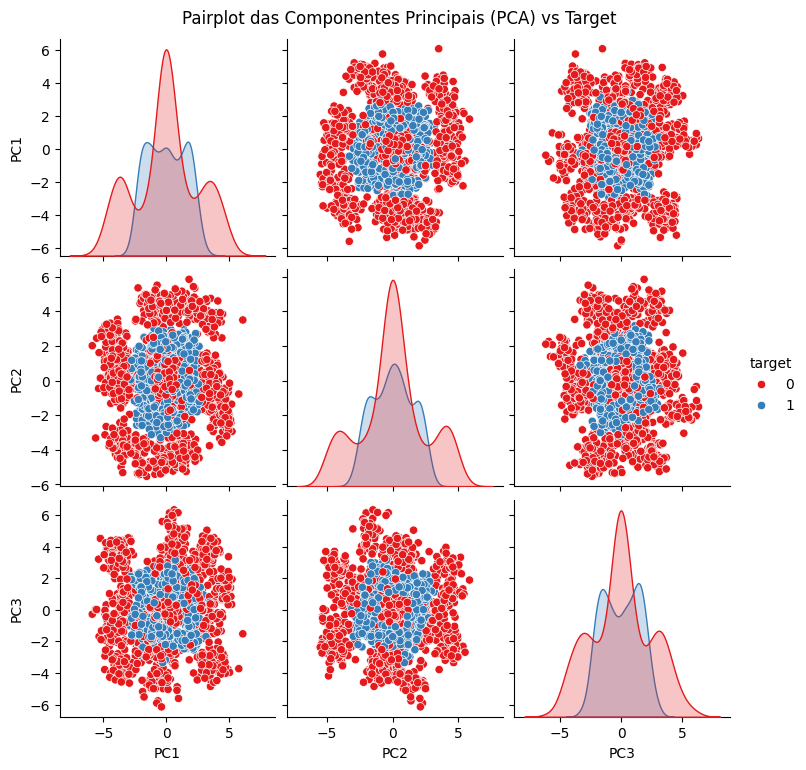

In [13]:
# Aplica scaler e PCA ao X_train e X_test, mas concatena para EDA
scaler = StandardScaler(with_std=False)
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Cria DataFrame com componentes principais e target
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
df_pca["target"] = y.values if hasattr(y, "values") else y

# EDA: pairplot das componentes principais colorido pelo target
sns.pairplot(df_pca, hue="target", diag_kind="kde", palette="Set1")
plt.suptitle("Pairplot das Componentes Principais (PCA) vs Target", y=1.02)
plt.show()